# Stock Price Analysis and Comparison

Vincent Luong

Write brief introduction about time series analysis

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

## Importing Datasets and Summary Statistics

### Tesla

In [2]:
tesla_dat = pd.read_csv('data/tesla.csv')
tesla_dat.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


From the tesla dataset, we have 7 features (1 categorical and 6 numerical):

-`Date`: The date M/D/Y<br>
-`Open`: The opening price of stock (in USD) <br>
-`High`: The high price of that day (in USD) <br>
-`Low`: The low price of that day (in USD) <br> 
-`Close`: The closed price of that day (in USD) <br>
-`Volume`: The amount of stocks traded during that day <br>
-`Adj Close`: The stock's closing price that has been amended to include any distributions/coporate actions that occurs before next days open (in USD) <br>

In [3]:
tesla_dat.describe

<bound method NDFrame.describe of             Date         Open         High         Low        Close  \
0     2010-06-29     3.800000     5.000000    3.508000     4.778000   
1     2010-06-30     5.158000     6.084000    4.660000     4.766000   
2     2010-07-01     5.000000     5.184000    4.054000     4.392000   
3     2010-07-02     4.600000     4.620000    3.742000     3.840000   
4     2010-07-06     4.000000     4.000000    3.166000     3.222000   
...          ...          ...          ...         ...          ...   
2951  2022-03-18   874.489990   907.849976  867.390015   905.390015   
2952  2022-03-21   914.979980   942.849976  907.090027   921.159973   
2953  2022-03-22   930.000000   997.859985  921.750000   993.979980   
2954  2022-03-23   979.940002  1040.699951  976.400024   999.109985   
2955  2022-03-24  1009.729980  1024.489990  988.799988  1013.919983   

        Adj Close    Volume  
0        4.778000  93831500  
1        4.766000  85935500  
2        4.392000  4109

In [4]:
tesla_dat.shape

(2956, 7)

In [5]:
tesla_dat['Date'].min()

'2010-06-29'

In [6]:
tesla_dat['Date'].max()

'2022-03-24'

**Note**: Since the format is Y-M-D, it looks like the data ranges from the start of June 2010 to March 2022, for a total of 12 years.

### S&P 500 

In [7]:
s500_dat = pd.read_csv('data/s500.csv')
s500_dat.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


From the S&P 500 dataset, we also have 7 features.  With 5 numerical features and 2 categorical features we have the following:

-`date`: The date Y-M-D <br>
-`open`: Price of the stock at market open (in USD) <br>
-`high`: Highest price reached that day (in USD) <br>
-`low`: lowest price reached in the day (in USD) <br>
-`Volume`: Number of shares traded <br>
-`Name`: The stock's ticker name

In [8]:
s500_dat.describe

<bound method NDFrame.describe of               date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]>

In [9]:
#See if this dataset includes TSLA stocks

#unique_count = s500_dat['Name'].unique()
#for name in unique_count:
#    print(name)


#Code ran and it doesn't include Stocks from TSLA

In [10]:
s500_dat.shape

(619040, 7)

In [11]:
s500_dat['date'].min()

'2013-02-08'

In [12]:
s500_dat['date'].max()

'2018-02-07'

**Note**: Since the format is Y/M/D, the data ranges from the start of Feburary 2013 to Feburary 2018, for a total of 5 years.

## Discovering Seperate Measurements

Since the Tesla dataset doesn't include any non-date categorical variables, we can ignore that and perform EDA on the S&P 500 dataset.

In [13]:
s500_dat.sort_values(by="date").head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.1200,14.630,14.75,8407500,AAL
508224,2013-02-08,81.22,81.9300,80.940,81.89,296853,SLG
506965,2013-02-08,78.24,79.0700,78.125,79.07,4632684,SLB
85755,2013-02-08,236.64,238.6924,235.750,238.16,552207,BLK
505706,2013-02-08,89.04,89.4800,88.910,89.16,554948,SJM


From the above, we definitely see stock prices flucutating on the same date for different names, now lets group by names

In [14]:
s500_dat.sort_values(by=["Name", "date"]).head()

,date,open,high,low,close,volume,Name
71611,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
71612,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
71613,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
71614,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
71615,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


Since we see that we have a sequence of dates with a single row per date, we can see that we have seperate timeseries for each combinations of `Name`.  This make sense as S&P 500 is an index fund composed of many stocks in the stock market.  To simplify the project, we will split the data to only analyze data that is from the **top 4 highest volumes** of trades.

## Finding the Markets with Highest Trade Volume

### Data Cleaning

In [15]:
#Convert to datetime
tesla_dat["Date"] = pd.to_datetime(tesla_dat["Date"])
s500_dat["date"] = pd.to_datetime(s500_dat["date"])

#make so tesla dataset uses 'date' instead of 'Date'
tesla_dat = tesla_dat.rename(columns={"Date": "date"})

In [16]:
#Code taken from Kaggle Notebook https://www.kaggle.com/code/avikumart/timeseries-stock-price-analysis-forecasting

# rename Name to ticks
rdf = s500_dat.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


C:\Users\vince\AppData\Local\Temp\ipykernel_7032\3230567191.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')


### Finding Highest Mean Volume

In [17]:
# find the average volume of each stocks using function and sort top 4 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top4_s = avaerage_s.sort_values(ascending=False)[:4]

print("Top 4 company tickers with highest average traded stock volume:\n", top4_s.index)

Length of the mean of ticks dictionary: 505
Top 4 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F'], dtype='object')


### Dividing the Dataframes

From the code above, we see that the markets with the highest volume are:
1. Bank of America
2. Apple
3. General Electric
4. Ford Motor Company

We will then divide the dataframes accordingly:

In [18]:
## Bank of America
bac = s500_dat.loc[s500_dat['Name'] == 'BAC']
bac.head()

,date,open,high,low,close,volume,Name
72870,2013-02-08,11.86,11.90,11.72,11.760,145217221,BAC
72871,2013-02-11,11.73,11.90,11.67,11.860,103499848,BAC
72872,2013-02-12,11.87,12.34,11.78,12.245,231771561,BAC
72873,2013-02-13,12.35,12.42,12.05,12.170,192478919,BAC
72874,2013-02-14,12.09,12.27,12.07,12.130,143901737,BAC


In [19]:
## Apple
apple = s500_dat.loc[s500_dat['Name'] == 'AAPL']
apple.head()

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [20]:
## General Electric
ge = s500_dat.loc[s500_dat['Name'] == 'GE']
ge.head()

,date,open,high,low,close,volume,Name
242754,2013-02-08,22.50,22.56,22.45,22.50,24424506,GE
242755,2013-02-11,22.49,22.51,22.35,22.45,19738628,GE
242756,2013-02-12,22.48,22.65,22.48,22.58,34139526,GE
242757,2013-02-13,23.11,23.48,23.04,23.39,84933955,GE
242758,2013-02-14,23.25,23.49,23.11,23.41,53990644,GE


In [21]:
## Facebook
fb = s500_dat.loc[s500_dat['Name'] == 'F']
fb.head()

,date,open,high,low,close,volume,Name
240236,2013-02-08,13.10,13.16,13.05,13.10,18596061,F
240237,2013-02-11,13.06,13.20,13.02,13.11,17685616,F
240238,2013-02-12,13.12,13.20,13.05,13.08,26231279,F
240239,2013-02-13,13.11,13.14,12.99,13.04,24501066,F
240240,2013-02-14,13.00,13.17,12.96,13.11,33487476,F


## Splitting the Data

Since there is mis-matching in the date ranges, we will focus on the dates the exists in both datasets to handle the differences in dates.

In [22]:
tesla_dat = tesla_dat[(tesla_dat['date'] >= '2013-02-08') & (tesla_dat['date'] <= '2018-02-07')]
print("Tesla Date Range:", tesla_dat["date"].min(), "to", tesla_dat["date"].max())
print("S&P 500 Date Range:", s500_dat["date"].min(), "to", s500_dat["date"].max())

Tesla Date Range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00
S&P 500 Date Range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00


Now that the dates are matched, we now have a total of 5 years of data from Feburary 2013 to Feburary 2018.  Lets split the data so we have **one year** of testing data for each dataframe.

In [23]:
#Creating Train/test split
split_date = pd.to_datetime('20170207', format='%Y%m%d')

tesla_train = tesla_dat[tesla_dat["date"] <= split_date]
tesla_test  = tesla_dat[tesla_dat["date"] >  split_date]

bac_train = bac[bac["date"] <= split_date]
bac_test = bac[bac["date"] > split_date]

apple_train = apple[apple["date"] <= split_date]
apple_test = apple[apple["date"] > split_date]

ge_train = ge[ge["date"] <= split_date]
ge_test = ge[ge["date"] > split_date]

fb_train = fb[fb["date"] <= split_date]
fb_test = fb[fb["date"] > split_date]

In [24]:
# Define a dictionary to hold the datasets
datasets = {
    "Tesla Train": tesla_train,
    "Tesla Test": tesla_test,
    "Bank of America Train": bac_train,
    "Bank of America Test": bac_test,
    "Apple Train": apple_train,
    "Apple Test": apple_test,
    "General Electric Train": ge_train,
    "General Electric Test": ge_test,
    "Facebook Train": fb_train,
    "Facebook Test": fb_test,
}

# Loop through the dictionary and print date ranges
for name, data in datasets.items():
    print(f"{name} Date Range: {data['date'].min()} to {data['date'].max()}")

Tesla Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Tesla Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Bank of America Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Bank of America Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Apple Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Apple Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
General Electric Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
General Electric Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Facebook Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Facebook Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00


## Explanatory Data Analysis

### Finding Missing Values 

We will first explore if there are any missing values, by using a dictionary and iterating through the datesets, we can explore the percentages of missing values for each respective dataset.  Ideally this should've been done before splitting because having missing values in our testing set could complicate our model and introduce bias.

In [25]:
# Define the datasets dictionary
datasets = {
    "Tesla": tesla_dat,
    "Bank of America": bac,
    "Apple": apple,
    "General Electric": ge,
    "Facebook": fb,
}

# Loop through the dictionary and calculate missing values
for name, df in datasets.items():
    print(f"Missing Values in {name}:")
    missing_percentage = (df.isnull().sum() / len(df)) * 100  # Calculate percentage
    print(missing_percentage)  # Print percentage of missing values for each column
    print("-" * 50)  # Separator for readability

Missing Values in Tesla:
date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64
--------------------------------------------------
Missing Values in Bank of America:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in Apple:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in General Electric:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in Facebook:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------


Luckily, there are no missing values in our main dataset, meaning, there are no missing values in our training/testing data splits.  This can mean we can move forward with our datasets.

### Adjusted Close Vs Close of Tesla Stocks

In the Telsa dataset, we have two different columns: `Close` and `Adj Close`.  In theory, it would be better to use the `Adj Close` column to find the adjusted closing price for the stock of tesla, however this might be seen as an advantage in comparison to the S&P 500 stocks, therefore we will first see if the 2 columns are the same first and move on from there.  

**Note** Ideally this should've been done before splitting the data

In [26]:
tesla_train.head()

,date,Open,High,Low,Close,Adj Close,Volume
658,2013-02-08,7.890,8.000,7.828,7.848,7.848,5699000
659,2013-02-11,7.596,7.830,7.500,7.684,7.684,16331500
660,2013-02-12,7.690,7.774,7.458,7.578,7.578,11306500
661,2013-02-13,7.660,7.800,7.610,7.690,7.690,4834000
662,2013-02-14,7.728,7.750,7.642,7.654,7.654,4953500


In [27]:
# Find rows where 'close' and 'adj_close' differ
differences = tesla_dat[tesla_dat["Close"] != tesla_dat["Adj Close"]]

print(f"Number of rows with differences: {len(differences)}")
print(differences)

Number of rows with differences: 0
Empty DataFrame
Columns: [date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [28]:
# Check if 'close' and 'adj_close' columns are identical
are_equal = tesla_dat["Close"].equals(tesla_dat["Adj Close"])

print("Are 'Close' and 'Adj Close' columns identical?", are_equal)

Are 'Close' and 'Adj Close' columns identical? True


Since these 2 columns are identical to one another and no advantage was given to `Adj Close` within this time frame, it can be reasonable to drop the `Adj Close` Column from the Tesla datasets.

In [29]:
#Drop columns
tesla_train = tesla_train.drop(columns=["Adj Close"])
tesla_test = tesla_test.drop(columns=["Adj Close"])

tesla_train.head()

,date,Open,High,Low,Close,Volume
658,2013-02-08,7.890,8.000,7.828,7.848,5699000
659,2013-02-11,7.596,7.830,7.500,7.684,16331500
660,2013-02-12,7.690,7.774,7.458,7.578,11306500
661,2013-02-13,7.660,7.800,7.610,7.690,4834000
662,2013-02-14,7.728,7.750,7.642,7.654,4953500


### Simple Plottings of Company Stock Prices and Volume of Trades

#### Tesla

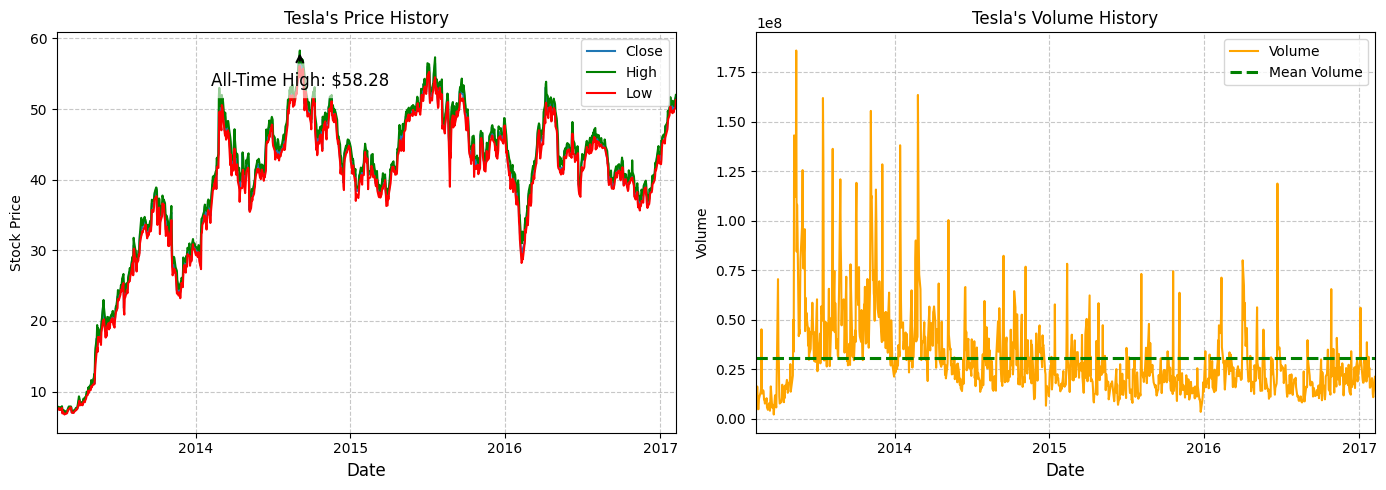

In [30]:
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(tesla_train["date"], tesla_train["Close"], label="Close")
ax1.plot(tesla_train["date"], tesla_train["High"], color="green", label="High")
ax1.plot(tesla_train["date"], tesla_train["Low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Tesla's Price History")
ax1.legend()

# Find the all-time high
all_time_high = tesla_train["High"].max()
all_time_high_date = tesla_train[tesla_train["High"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(tesla_train["date"], tesla_train["Volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=tesla_train['Volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Tesla's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([tesla_train["date"].min(), tesla_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Producing the scatterplots for Stock Price and Dates we can see that Tesla had an upwards trend from 2013 to the middle of 2014, then it got relatively stable with most of its volume of trades happening around 2014.

#### Bank Of America

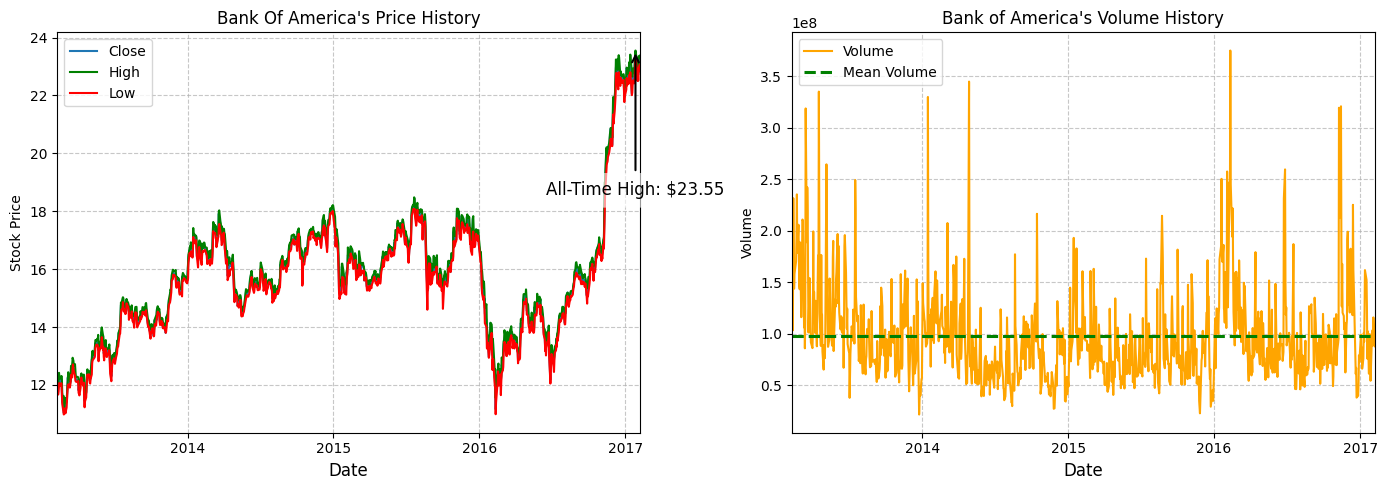

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(bac_train["date"], bac_train["close"], label="Close")
ax1.plot(bac_train["date"], bac_train["high"], color="green", label="High")
ax1.plot(bac_train["date"], bac_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Bank Of America's Price History")
ax1.legend()

# Find the all-time high
all_time_high = bac_train["high"].max()
all_time_high_date = bac_train[bac_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(bac_train["date"], bac_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=bac_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Bank of America's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([bac_train["date"].min(), bac_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Looking at the Bank of America charts, we can see that the stock price was increasing until 2014 and reamined relatively stable until 2016.  It is then met with a drop in stock price followed by a drastic increase in stock price.  Looking at the `volume` history, we can see that the trades for this stock market are relatively stable.

#### Apple

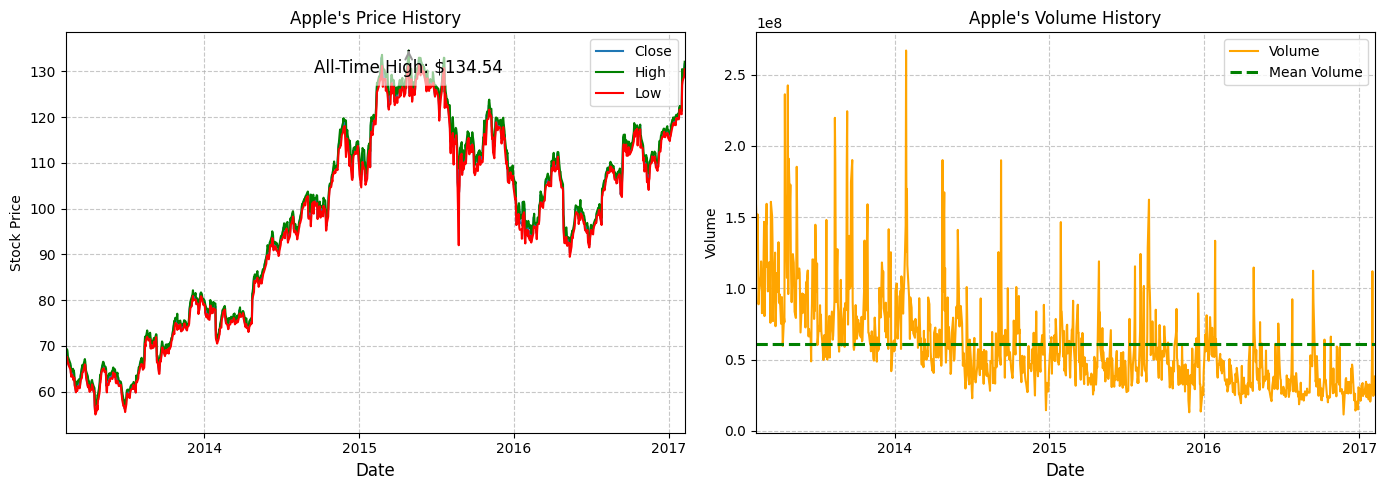

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(apple_train["date"], apple_train["close"], label="Close")
ax1.plot(apple_train["date"], apple_train["high"], color="green", label="High")
ax1.plot(apple_train["date"], apple_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Apple's Price History")
ax1.legend()

# Find the all-time high
all_time_high = apple_train["high"].max()
all_time_high_date = apple_train[apple_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(apple_train["date"], apple_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=apple_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Apple's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([apple_train["date"].min(), apple_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Viewing the scatterplots for Apple, we see that the stock price of apple has been increaseing from the start till around mid-2015.  Then it is met with a decrease until mid 2016.  Lastly the stock price has been increasing since.  Moving over to the `volume` history of Apple, we can see that the `volume` of trades happening at apple has a decreasing trend over time, but still remained relatively stable.

#### General Electric

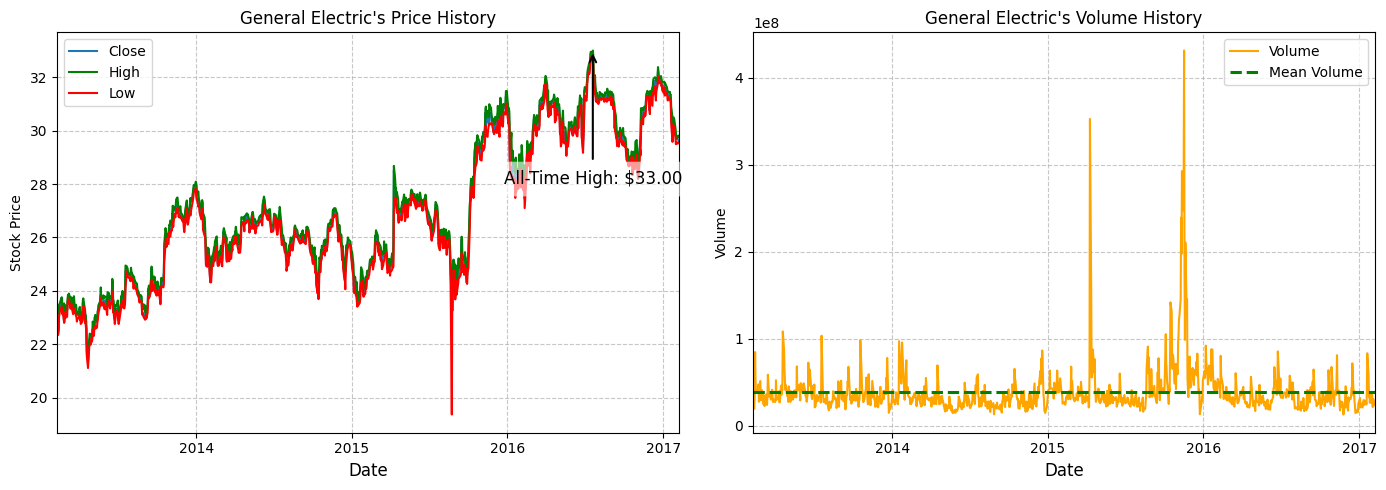

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(ge_train["date"], ge_train["close"], label="Close")
ax1.plot(ge_train["date"], ge_train["high"], color="green", label="High")
ax1.plot(ge_train["date"], ge_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("General Electric's Price History")
ax1.legend()

# Find the all-time high
all_time_high = ge_train["high"].max()
all_time_high_date = ge_train[ge_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(ge_train["date"], ge_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=ge_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("General Electric's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([ge_train["date"].min(), ge_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

The Stock Price for General Electric seems to vary a lot throughout the years; an interesting thing to note is the huge crash in the stock market near mid 2015.  While looking at the `volume` history, we can see that the `volume` of trades remained very stabled throughout the years, but with 2 huge spikes between 2015 and 2016.

#### Facebook

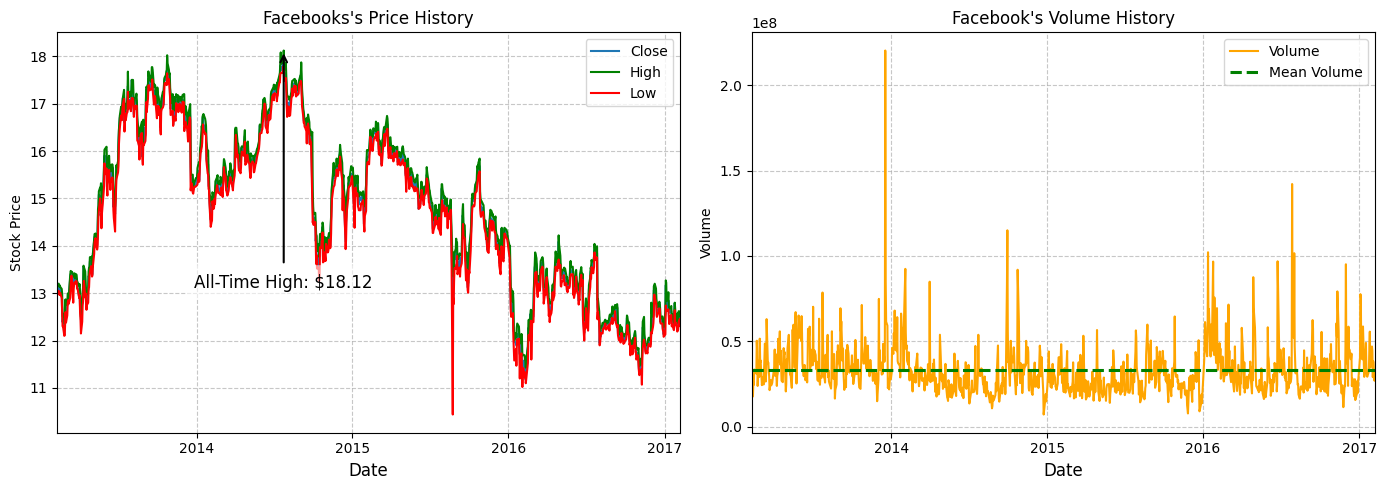

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(fb_train["date"], fb_train["close"], label="Close")
ax1.plot(fb_train["date"], fb_train["high"], color="green", label="High")
ax1.plot(fb_train["date"],fb_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Facebooks's Price History")
ax1.legend()

# Find the all-time high
all_time_high = fb_train["high"].max()
all_time_high_date = fb_train[fb_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(fb_train["date"], fb_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=fb_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Facebook's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([fb_train["date"].min(), fb_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Looking at Facebook's stock market history we can see a decling trend throughout the years with a massive crash in the middle of 2015.  Moving on to the `volume` history of Facebook, we can see that it also remained relatively stable, with some huge increases for some dates.

#### General Inference

We notice for all the scatterplots, we can see a massive stock crash near the middle of 2015.  We can attribute it to the 2015-201 [stock market selloff](https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=Stock%20market%20performance%20in%20mid%2D2015,-The%20DJIA%20closed&text=The%20stock%20market%20slowly%20slid,%24105%20by%20August%2021%2C%202015.), this is when the **SSE Composite Index** fell 43% in just over 2 months between June 2015 and August 2015 which devalued the currency of the Chinese yuian which scared investors into selling shares globally.  As shown visually above, we can see the most of the *S&P 500* companies suffered drastically from this event.

#### Key Observations

1. For our 5 companies we are analyzing, we have following companies:
   - **1 Bank: Bank Of America**
   - **3 Tech: Tesla, Apple, Facebook**
   - **1 Electrical: General Electric**

2. Facebook seems to be the only declining stock

3. Generel Electric, Apple, and Bank of America have an increasing stock market

4. Tesla has a relatively stable stock market

## Feature Engineering

Add `daily_mean` feature where it is `open + close + high + low`/4

add `daily_return` feature where it is $\frac{close-open}{open}$ * 100

### Creating Lagged Features

We will be now trying to forecast the future stock price. The function below is adapted from [UBC CPSC 330](https://ubc-cs.github.io/cpsc330-2024W1/lectures/notes/19_intro_to_computer-vision.html) , with some improvements.

In [35]:
def create_lag_feature_single(df, orig_feature, lag, new_feature_name=None, clip=False):
    """
    Creates a lagged version of an existing feature for a single time series.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying.
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future.
    new_feature_name : str
        Override the default name of the newly created column.
    clip : bool
        If True, remove rows with NaN values for the new feature.

    Returns
    -------
    pandas.core.frame.DataFrame
        A new DataFrame with the additional lagged column.
    """
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = f"{orig_feature}_lag{-lag}"
        else:
            new_feature_name = f"{orig_feature}_ahead{lag}"
    
    # Add the new lagged column
    df[new_feature_name] = df[orig_feature].shift(-lag)

    # Clip rows with NaN values if requested
    if clip:
        df = df.dropna(subset=[new_feature_name])

    return df

We need to first make sure the datasets are sorted by `Date`, however, this is already ensured as shown near the beginnings of the dataset, therefore no code has to be done.

<br>
<br>

Now we will be **lagging** the `close` feature of the datasets and make a new feature `close_tom`.  This will the `close` price of tomorrows stock market.  We have `clip=True` to remove for any missing values, however this is not needed as we do not have any missing variables in our dataset.

### Tesla Lagged Feature

In [36]:
tesla_train = tesla_train.sort_values(by="date")

In [44]:
# Lag the Close price by 1 day
tesla_lagged_train= create_lag_feature_single(
    tesla_train,
    orig_feature="Close",
    lag=1,  # Lagging by 1 day into the past
    new_feature_name = "close_tom",
    clip = True
)

tesla_lagged_train

,date,Open,High,Low,Close,Volume,close_tom
658,2013-02-08,7.890000,8.000000,7.828000,7.848000,5699000,7.684000
659,2013-02-11,7.596000,7.830000,7.500000,7.684000,16331500,7.578000
660,2013-02-12,7.690000,7.774000,7.458000,7.578000,11306500,7.690000
661,2013-02-13,7.660000,7.800000,7.610000,7.690000,4834000,7.654000
662,2013-02-14,7.728000,7.750000,7.642000,7.654000,4953500,7.408000
...,...,...,...,...,...,...,...
1659,2017-01-31,49.848000,51.178001,49.540001,50.386002,20580500,49.848000
1660,2017-02-01,50.610001,50.639999,49.810001,49.848000,19794000,50.310001
1661,2017-02-02,49.667999,50.484001,49.542000,50.310001,12499000,50.265999
1662,2017-02-03,50.382000,50.436001,49.936001,50.265999,10933500,51.554001


In [45]:
# Lagging the testing set
tesla_lagged_test = create_lag_feature_single(
    tesla_test,
    orig_feature = "Close",
    lag = 1,
    new_feature_name = "close_tom",
    clip = True
)